# Predicción resultados partigas PUBG - Segunda entrega

![image info](https://assets.goal.com/v3/assets/bltcc7a7ffd2fbf71f5/bltef3283334c7a2677/60de056d2446e93b5b6c87d6/8d9c326c1ca413195b04107a072c6e81a27962e0.jpg)

**Introducción.** El Players Unknown Battlegrounds (PUBG de aqui en adelante) es un videojuego disponible para varias consolas (PC, PS4, PS5, Xbox y móviles) de los denominados battle royale, que puede jugarse en primera o tercera persona. Hasta un máximo de 100 jugadores saltan en paracaídas de un avion en algun momento de su recorrido, aterrizando en un mapa completamente desequipados. A partir de allí buscaran equiparse lo mejor que puedan con armas, municiones, miras, consumibles; teniendo como objetivo final matar al resto de los jugadores y ser los ultimos en pie. La partida puede jugarse solo o en modo cooperativo, y la zona de mapa habitable se va cerrando con el paso del tiempo forzando asi encuentros entre jugadores.

**Contexto empresarial.** Un sitio de apuestas online desea incluir entre sus eventos de apuesta, las partidas del torneo 'PUBG Global Championship'. Para ello, requieren poder predecir el resultado de las mismas, de manera que luego ellos puedan calcular las cuotas deportivas y los favoritos a ganar cada fase (y ajustar las mismas conforme esta se vaya desarrollando); tomando apuestas de acuerdo a esta información.

**Problema comercial.** Su tarea consistirá en predecir el resultado de una partida.

**Contexto analítico.** En entregas anteriores, se recopiló un conjunto de datos con resultados de partidas para jugadores de diverso nivel, y sus correspondientes estadísticas. Este presentaba métricas como asistencias, distancia recorrida a pie, en vehículos, daño inflingido, etc. y por supuesto ranking final en la partida. Los datos fueron cargados desde un archivo '.csv', y a partir de estos se construyó un modelo de prediccion del ranking. Luego nos comunicamos con el servidor de PUBG a traves de la API, y descargamos las últimas partidas de jugadores específicos (las correspondientes a los últimos 14 días, que es lo que guarda el servidor). En esta entrega se procesará la información descargada, limpiandola de ser necesario y se presentaran insights a partir de ella.

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 22.6 MB 23.2 MB/s 0:00:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 42.2 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=352322 sha256=806e6da17bec5c42b177f3e89621e0f1b9f1611afc2c08c1f7c95c9b038cf318
  Stored in directory: /tmp/pip-ephem-wheel-cache-zg5dmibt/wheels/07/29/61/f533cc7cbd0a97efb2d1b94d3254a3e859a949367ba842577b
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 

In [ ]:
import requests
import json
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import ydata_profiling

# Shard specification: url = "https://api.pubg.com/shards/[SHARD HERE]/"
# El shard hace referencia a la plataforma de la que se buscan datos (Xbox, PS4, PS5, PC, Mobile)

url = "https://api.pubg.com/shards/steam/"

# "Authorization": "Bearer [API KEY HERE]",

key = "" # Insertar API Key

headers = {
  "Authorization": "Bearer "+ key,
  "Accept": "application/vnd.api+json"
}

In [ ]:
# Lista de nombres de jugadores
player_name = ['xmpl', 'ADOUZ1E', 'f1lfirst', 'Besto', 'Qwizzy', 'GOOSYARA666', 'fate', 'hallomybad', 'HalloSenpai', 'xwudd', 'Kickstart', 'TGLTN',
               'Snakers', '2heart', 'Akita', 'Ming', 'Perfect1ks', 'D1gg3r1', 'Shrimzy', 'Nourinz', 'Hikari', 'jeemzz', 'Fexx', 'Inonix', 'Relo',
               'Marcelek', 'penta', 'Seongjang', 'DG98', 'Aitzy', 'DuCkHjeUz', 'Nannnnn', 'nicoos', 'LashK', 'KnorkiS', 'hwinn', 'sparkingg',
               'Ykikamucow', 'PurdyKurty', 'M1ME', 'Noardra', 'Mellman', 'Lukarux', 'K4pii', 'Naylup', 'Krunio', 'clib', 'Molodoct']

# Se inicializa el dataframe donde se volcará la información de la partida, y se crea la columna extra que guardará las fechas
data = pd.DataFrame()
data.insert(0, column='dates', value=None)

def participant_performance(player_name, match_stat):

  """ Función que devuelve stats finales de la partida para el jugador e id de partida especificados """
  sub = pd.Series(dtype='object')
  match_included = match_stat['included']
  for i in match_included:
    if (i['type'] == 'participant' and i['attributes']['stats']['name'] == player_name):
      sub = i['attributes']['stats']
  return sub

# Se hace una iteración por todos los nombres de jugadores especificados
for plyr in player_name:
  # Se filtra la url por nombre de jugador
  player_stats_url = url + "players?filter[playerNames]=" + plyr

  # Se realiza el requests; si es exitoso se descarga la información del jugador, caso contrario pasa al siguiente de la lista
  r = requests.get(player_stats_url, headers = headers)
  if r.status_code == 200:
	  print(plyr, "successfully retrieved!!!")
  else:
    print(plyr, "failed to Connect!!!")
    continue

  # Se pone un tiempo de espera de 6s para que el servidor no me corte el acceso
  time.sleep(6)
  player_stat = json.loads(r.text)
  match_id_list = player_stat['data'][0]['relationships']['matches']['data']

  # Por cada jugador, se realiza una iteración por cada una de sus partidas
  for match in match_id_list:
    match_id = match['id']
    match_url = url + "matches/{}".format(match_id)
    match_r = requests.get(match_url, headers = headers)
    if match_r.status_code != 200:
      print("\tFailed to connect to match data!!!")
      continue
    match_stat = json.loads(match_r.text)

    # Se van concatenando los resultados de cada partida para cada jugador, y las fechas en una lista aparte
    data = pd.concat([data, pd.Series(participant_performance(plyr, match_stat)).to_frame().T])
    data.iloc[-1, 0] = match_stat['data']['attributes']['createdAt']

xmpl successfully retrieved!!!
ADOUZ1E successfully retrieved!!!
f1lfirst successfully retrieved!!!
Besto successfully retrieved!!!
Qwizzy successfully retrieved!!!
GOOSYARA666 successfully retrieved!!!
fate successfully retrieved!!!
hallomybad successfully retrieved!!!
HalloSenpai successfully retrieved!!!
xwudd successfully retrieved!!!
Kickstart successfully retrieved!!!
TGLTN successfully retrieved!!!
Snakers successfully retrieved!!!
2heart successfully retrieved!!!
Akita successfully retrieved!!!
Ming successfully retrieved!!!
Perfect1ks successfully retrieved!!!
D1gg3r1 successfully retrieved!!!
Shrimzy successfully retrieved!!!
Nourinz successfully retrieved!!!
Hikari successfully retrieved!!!
jeemzz successfully retrieved!!!
Fexx successfully retrieved!!!
Inonix successfully retrieved!!!
Relo successfully retrieved!!!
Marcelek successfully retrieved!!!
penta successfully retrieved!!!
Seongjang successfully retrieved!!!
DG98 successfully retrieved!!!
Aitzy successfully retrieve

In [ ]:
data.reset_index(inplace=True, drop=True)

data.head()

,dates,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,2023-06-12T22:49:37Z,2,3,6,700.63983,byplayer,1,4,4,2,...,2,2997.2002,0,0,0,955,0,1429.9155,7,8
1,2023-06-12T22:16:33Z,1,0,2,88.48501,byplayer,0,1,47,0,...,0,1292.3624,0,0,0,501,0,561.2595,5,11
2,2023-06-12T22:03:44Z,1,2,1,298.21686,byplayer,0,7,17,1,...,0,0,0,0,0,587,0,734.88055,5,11
3,2023-06-12T21:31:00Z,9,5,9,1268.585,byzone,4,7,1,3,...,0,0,0,19.985155,0,1698,0,1173.8966,9,3
4,2023-06-12T19:57:19Z,8,2,4,1037.2031,alive,4,5,2,3,...,0,0,0,0,0,1631,0,134.84604,7,1


In [ ]:
data.shape

(3263, 24)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   dates            3263 non-null   object
 1   DBNOs            3238 non-null   object
 2   assists          3238 non-null   object
 3   boosts           3238 non-null   object
 4   damageDealt      3238 non-null   object
 5   deathType        3238 non-null   object
 6   headshotKills    3238 non-null   object
 7   heals            3238 non-null   object
 8   killPlace        3238 non-null   object
 9   killStreaks      3238 non-null   object
 10  kills            3238 non-null   object
 11  longestKill      3238 non-null   object
 12  name             3238 non-null   object
 13  playerId         3238 non-null   object
 14  revives          3238 non-null   object
 15  rideDistance     3238 non-null   object
 16  roadKills        3238 non-null   object
 17  swimDistance     3238 non-null   

Se observa que la columna 'dates' tiene algunos registros mas no nulos que el resto, por lo que existen filas vacías.

In [ ]:
data[data.DBNOs.isnull()]

,dates,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
1605,2023-06-04T16:00:47Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1606,2023-06-04T01:43:58Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1607,2023-06-04T01:30:12Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1608,2023-06-04T01:20:56Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1609,2023-06-04T01:12:31Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1610,2023-06-03T16:13:07Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1611,2023-06-03T15:48:21Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1612,2023-06-03T15:41:07Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1613,2023-06-03T15:16:03Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1614,2023-06-03T14:52:59Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Aquí se observan.

In [ ]:
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

Se eliminan esas filas y se resetea el index.

In [ ]:
data['dates'] = pd.to_datetime(data['dates'])
data = data.astype({'DBNOs' : 'int',
                    'assists' : 'int',
                    'boosts' : 'int',
                    'damageDealt' : 'float',
                    'headshotKills' : 'int',
                    'heals' : 'int',
                    'killPlace' : 'int',
                    'killStreaks' : 'int',
                    'kills' : 'int',
                    'longestKill' : 'float',
                    'revives' : 'int',
                    'rideDistance' : 'float',
                    'roadKills' : 'int',
                    'swimDistance' : 'float',
                    'teamKills' : 'int',
                    'timeSurvived' : 'int',
                    'vehicleDestroys' : 'int',
                    'walkDistance' : 'float',
                    'weaponsAcquired' : 'int',
                    'winPlace' : 'int'
             })

Se transforma cada columna en el tipo de dato que corresponde.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3238 entries, 0 to 3237
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   dates            3238 non-null   datetime64[ns, UTC]
 1   DBNOs            3238 non-null   int64              
 2   assists          3238 non-null   int64              
 3   boosts           3238 non-null   int64              
 4   damageDealt      3238 non-null   float64            
 5   deathType        3238 non-null   object             
 6   headshotKills    3238 non-null   int64              
 7   heals            3238 non-null   int64              
 8   killPlace        3238 non-null   int64              
 9   killStreaks      3238 non-null   int64              
 10  kills            3238 non-null   int64              
 11  longestKill      3238 non-null   float64            
 12  name             3238 non-null   object             
 13  playerId         3

In [ ]:
data.head()

,dates,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,2023-06-12 22:49:37+00:00,2,3,6,700.63983,byplayer,1,4,4,2,...,2,2997.2002,0,0.000000,0,955,0,1429.91550,7,8
1,2023-06-12 22:16:33+00:00,1,0,2,88.48501,byplayer,0,1,47,0,...,0,1292.3624,0,0.000000,0,501,0,561.25950,5,11
2,2023-06-12 22:03:44+00:00,1,2,1,298.21686,byplayer,0,7,17,1,...,0,0.0000,0,0.000000,0,587,0,734.88055,5,11
3,2023-06-12 21:31:00+00:00,9,5,9,1268.58500,byzone,4,7,1,3,...,0,0.0000,0,19.985155,0,1698,0,1173.89660,9,3
4,2023-06-12 19:57:19+00:00,8,2,4,1037.20310,alive,4,5,2,3,...,0,0.0000,0,0.000000,0,1631,0,134.84604,7,1


In [ ]:
data.duplicated().sum()

0

No existen registros duplicados.

La primer entrega de nuestro proyecto, se basó en el análisis de la información proveniente de un archivo .csv, el cual tenía una estructura muy similar a la obtenida de la API, con la diferencia de que el archivo poseía información de jugadores de nivel promedio. Los jugadores participantes del torneo tienen un desempeño a nivel competitivo; si pretendemos predecir resultados para dicho grupo, la información del archivo no nos aporta datos utiles. En lugar de eso debemos cargar sus nombres en la lista para descargar sus historiales de partidas y analizarlos.

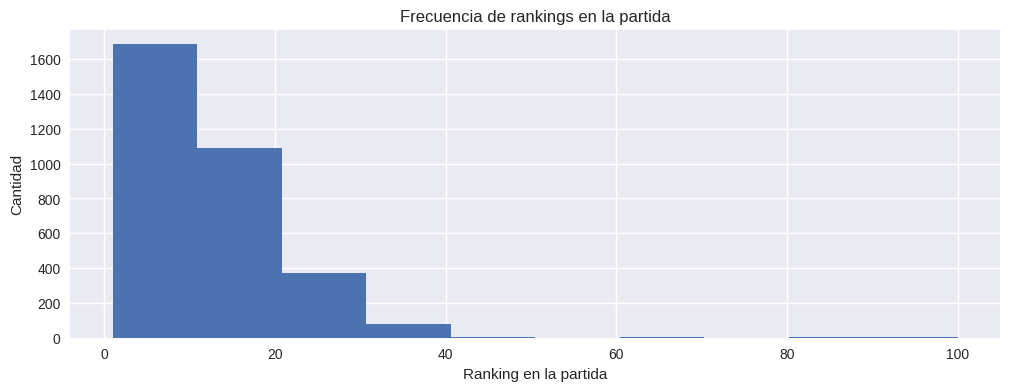

In [ ]:
mpl.style.use('seaborn-v0_8')

plt.figure(figsize=(12, 4))
plt.hist(data.winPlace)
plt.xlabel('Ranking en la partida')
plt.title('Frecuencia de rankings en la partida')
plt.ylabel('Cantidad')
plt.show()

Viendo la distribución de nuestra variable objetivo (ranking en la partida), se observa que la misma posee un sesgo hacia la derecha. Esto se traduce en que los resultados para las partidas analizadas tienden a mostrar buenos rankings, lo cual es de esperarse ya que nos estamos concentrando en jugadores profesionales.

### Profiling

In [ ]:
#Data Profiling
profile = ydata_profiling.ProfileReport(data)
profile

Output hidden; open in https://colab.research.google.com to view.

### Preguntas puntuales

A partir de la información obtenida pueden responderse algunas preguntas como:
* Los jugadores de nivel competitivo han desarrollado buena punteria?
* Cual es el tipo de muerte mas predominante?
* Es importante el uso de vehículos para mejorar la supervivencia?
* Hay algún día de la semana donde se jueguen mas partidas? Mejora la performance en dichos días?

y a partir de estas:
* Cuales son las features que mayor influencia tienen en el resultado de una partida?

#### Los jugadores de nivel competitivo han desarrollado buena punteria?

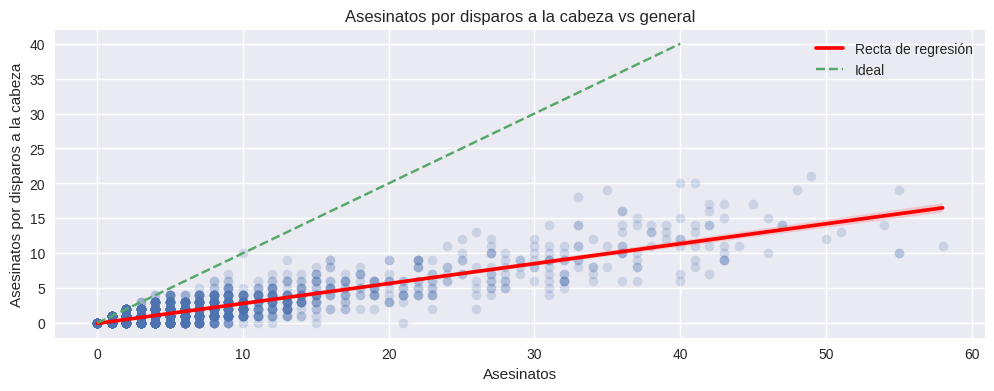

In [ ]:
plt.figure(figsize=(12, 4))
sns.regplot(data=data, x='kills', y='headshotKills',
            scatter_kws={'alpha':.2},
            line_kws={"color": "red"})
plt.plot([0, 40], [0, 40], ls="dashed")
plt.legend(['_','Recta de regresión', '_', 'Ideal'])
plt.xlabel('Asesinatos')
plt.ylabel('Asesinatos por disparos a la cabeza')
plt.title('Asesinatos por disparos a la cabeza vs general')

warnings.filterwarnings("ignore", category=UserWarning)

plt.show()

Nota: la cabeza es el lugar del cuerpo donde mas daño produce un disparo, seguido por el torso y por último las extremidades. Por esta razón es que resulta conveniente intentar dar en esa zona del cuerpo del enemigo siempre que sea posible (por una cuestión de superficie resulta mas sencillo dar en el torso). Un disparo con un rifle de alto calibre a la cabeza matará instantaneamente al enemigo excepto que este posea un casco.


En este gráfico se observa la alta correlación que existe entre asesinatos por disparos a la cabeza vs los generales. Pero probablemente lo mas interesante sea comparar dicha recta de regresión con el ideal (todos los asesinatos son realizados por disparos a la cabeza). Mientras mas se aparte una recta de otra, peor es la punteria del jugador o a lo sumo mas ineficiente. Habría que comparar este gráfico con uno realizado para jugadores a nivel no competitivo (el archivo '.csv' de entregas anteriores); se tendería a pensar que dicha recta se apartaría mas aun del ideal que la aquí obtenida.

#### Cual es el tipo de muerte mas predominante?

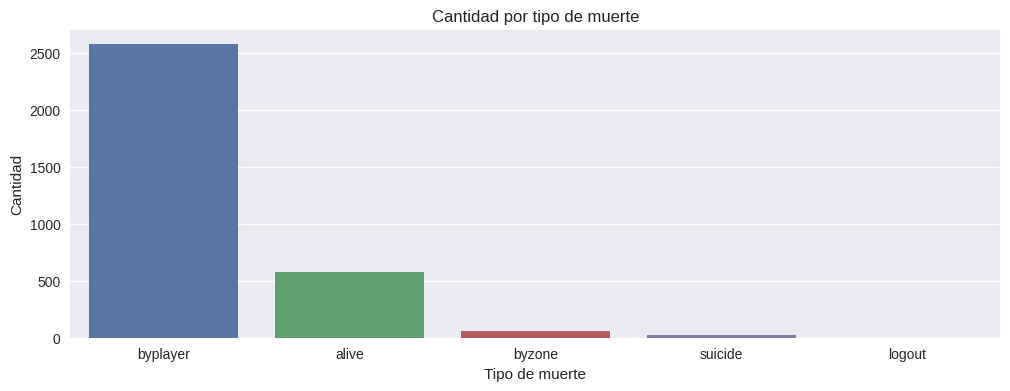

In [ ]:
plt.figure(figsize=(12, 4))
sns.countplot(data=data, x='deathType', order=data.deathType.value_counts().index)
plt.xlabel('Tipo de muerte')
plt.ylabel('Cantidad')
plt.title('Cantidad por tipo de muerte')
plt.show()

Se observa que la mayor parte de los jugadores mueren asesinados por otro jugador, luego le sigue un grupo pequeño que se encuentran vivos al finalizar (son los ganadores de la partida), y por último un grupo mínimo de jugadores que mueren ya sea por la zona (cierre del mapa con el paso del tiempo), por suicidio o desconexión.

#### Es importante el uso de vehículos para mejorar la supervivencia?

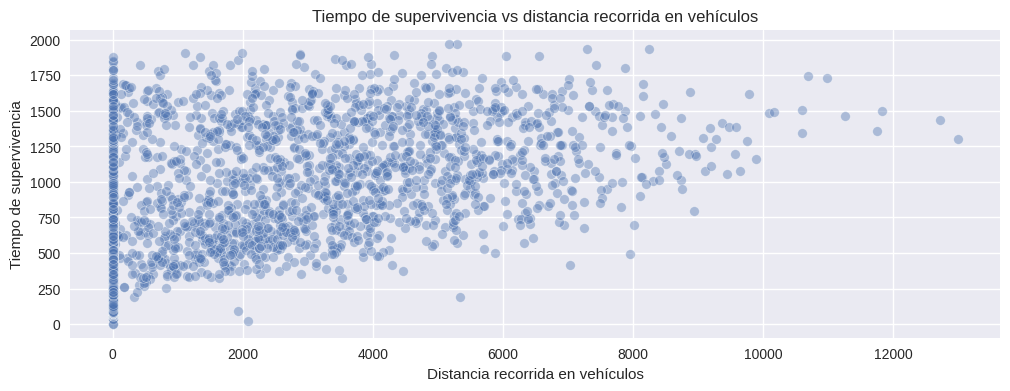

In [ ]:
plt.figure(figsize=(12, 4))
sns.scatterplot(data=data, x='rideDistance', y='timeSurvived', alpha=.4)
plt.xlabel('Distancia recorrida en vehículos')
plt.ylabel('Tiempo de supervivencia')
plt.title('Tiempo de supervivencia vs distancia recorrida en vehículos')
plt.show()

En este caso, se ha graficado el tiempo de supervivencia vs la distancia recorrida en vehículo. Pueden observarse 2 grupos; el primero posee una distancia recorrida de 0 (jugadores que no utilizaron vehículos) y sus tiempos de supervivencia se encuentran distribuidos desde valores mínimos hasta máximos de la serie. El segundo grupo se conforma por jugadores que si utilizaron vehículos, en este caso se observa que a mayor distancia recorrida en ellos, mayor tiende a ser el tiempo de supervivencia.

#### Hay algún día de la semana donde se jueguen mas partidas? Mejora la performance en dichos días?

In [ ]:
data['weekday'] = data['dates'].dt.weekday
weekday_dict = {0 : 'Monday',
                1 : 'Tuesday',
                2 : 'Wednesday',
                3 : 'Thursday',
                4 : 'Friday',
                5 : 'Saturday',
                6 : 'Sunday'}
data['weekday'] = data['weekday'].map(weekday_dict)
# Se extrae el número de dia de la semana, y se remplaza por su nombre correspondiente
data.head()

,dates,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,...,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,weekday
0,2023-06-12 22:49:37+00:00,2,3,6,700.63983,byplayer,1,4,4,2,...,2997.2002,0,0.000000,0,955,0,1429.91550,7,8,Monday
1,2023-06-12 22:16:33+00:00,1,0,2,88.48501,byplayer,0,1,47,0,...,1292.3624,0,0.000000,0,501,0,561.25950,5,11,Monday
2,2023-06-12 22:03:44+00:00,1,2,1,298.21686,byplayer,0,7,17,1,...,0.0000,0,0.000000,0,587,0,734.88055,5,11,Monday
3,2023-06-12 21:31:00+00:00,9,5,9,1268.58500,byzone,4,7,1,3,...,0.0000,0,19.985155,0,1698,0,1173.89660,9,3,Monday
4,2023-06-12 19:57:19+00:00,8,2,4,1037.20310,alive,4,5,2,3,...,0.0000,0,0.000000,0,1631,0,134.84604,7,1,Monday


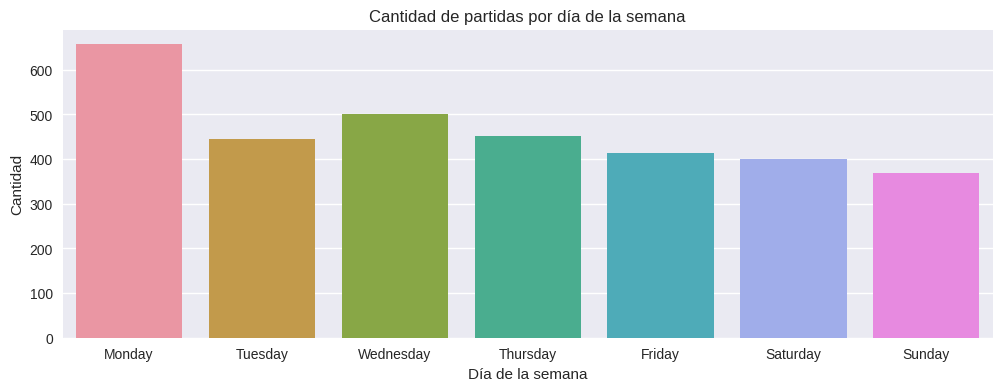

In [ ]:
plt.figure(figsize=(12, 4))
sns.countplot(data=data, x='weekday', order=weekday_dict.values())
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad')
plt.title('Cantidad de partidas por día de la semana')
plt.show()

Se observa un pico de cantidad de partidas los Lunes, y luego el valor se mantiene alrededor de un promedio cercano a 400 para el resto de la semana.

In [ ]:
win_day = data.groupby('weekday')[['winPlace']].mean().reindex(weekday_dict.values())
win_day

,winPlace
weekday,
Monday,12.050228
Tuesday,9.466216
Wednesday,12.045908
Thursday,11.564159
Friday,10.578692
Saturday,11.423940
Sunday,10.772973


Se realiza un agrupamiento por día de la semana y se calcula el ranking medio para cada día.

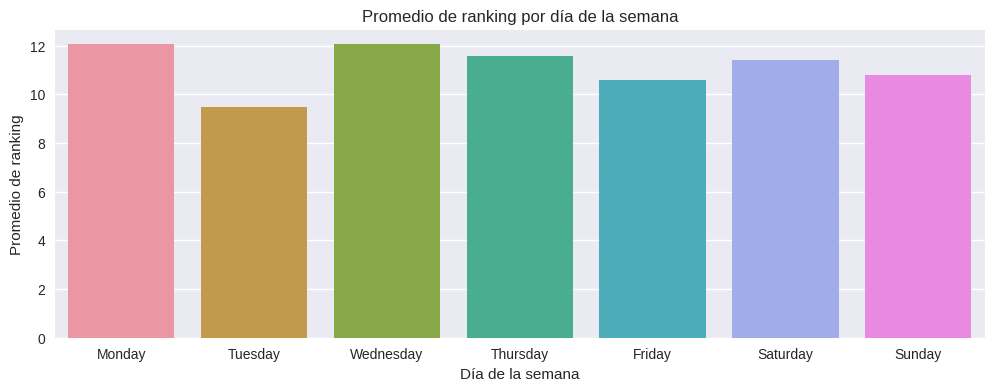

In [ ]:
plt.figure(figsize=(12, 4))
sns.barplot(data=win_day, x=win_day.index, y='winPlace')
plt.xlabel('Día de la semana')
plt.ylabel('Promedio de ranking')
plt.title('Promedio de ranking por día de la semana')
plt.show()

Nota: recordar que a menor nro de ranking, mejor es la posición obtenida.

Los días Martes, los rankings tienden a ser mejores.

#### Cuales son las features que mayor influencia tienen en el resultado de una partida?

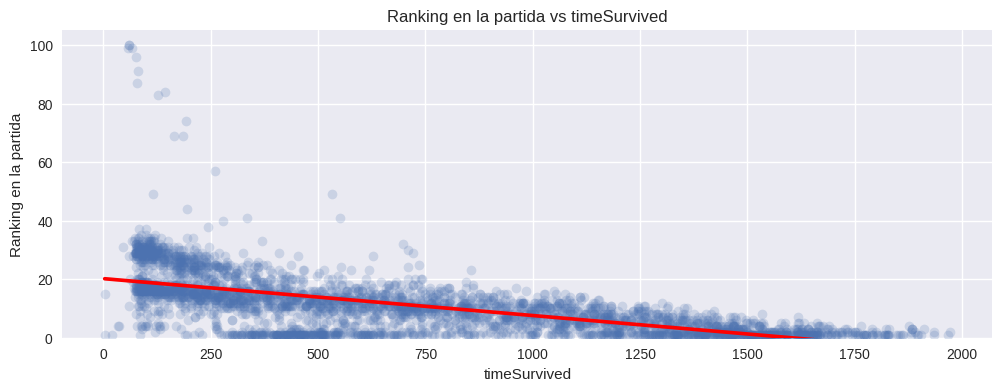

In [ ]:
plt.figure(figsize=(12, 4))
sns.regplot(data=data, x='timeSurvived', y='winPlace',
            scatter_kws={'alpha':.2},
            line_kws={"color": "red"})
plt.ylim(bottom=0)
plt.xlabel('timeSurvived')
plt.ylabel('Ranking en la partida')
plt.title('Ranking en la partida vs timeSurvived')
plt.show()

Si bien nuestra variable objetivo sigue siendo 'winPlace' -es decir el ranking en la partida-, para esta presentación nos centraremos en el tiempo de supervivencia del jugador.

Nota: recordar que a menor 'winPlace', mejor ranking en la partida; y la partida de un jugador se da por terminada cuando este muere o es el último en pie.
Si descartamos algunas partidas de tiempo de supervivencia medio con buen ranking, situadas sobre el eje X (podrían tratarse de partidas personalizadas con bots, o una con menor cantidad de jugadores, o modos de juego especiales); puede observarse que a mayor tiempo de supervivencia mejor es el ranking (menor 'winPlace').

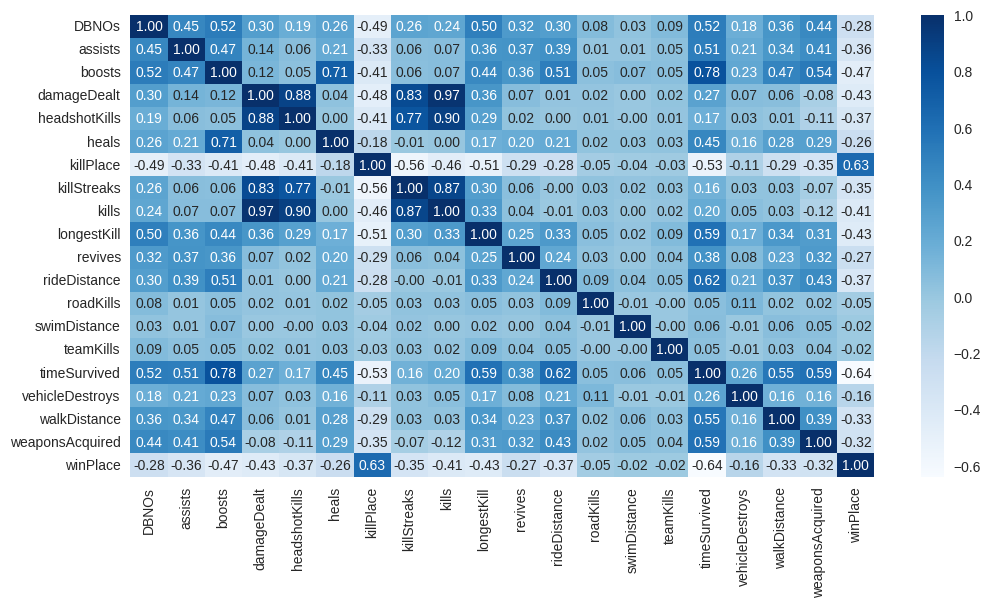

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', fmt='.2f')
plt.show()

Nos concentraremos entonces en variables que mayor correlación tienen con el tiempo de supervivencia, siendo estas 'boosts', 'longestKill', 'rideDistance' (ya analizada) y 'weaponsAcquired'.

#### boosts

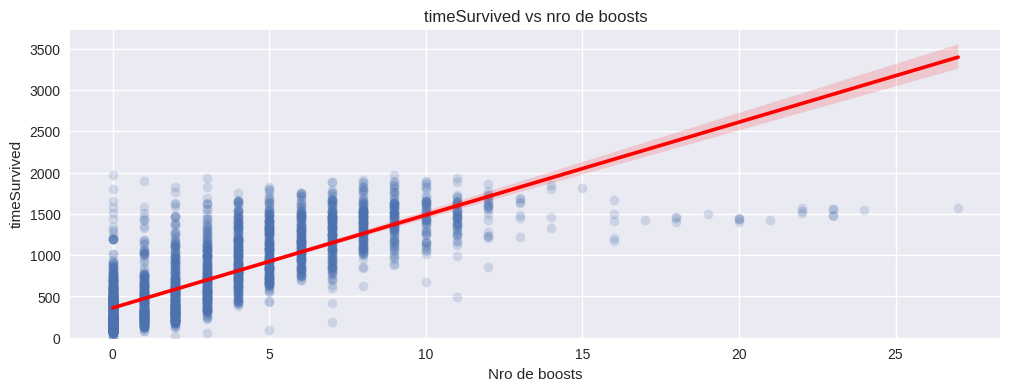

In [ ]:
plt.figure(figsize=(12, 4))
sns.regplot(data=data, x='boosts', y='timeSurvived',
            scatter_kws={'alpha':.2},
            line_kws={"color": "red"})
plt.ylim(bottom=0)
plt.xlabel('Nro de boosts')
plt.ylabel('timeSurvived')
plt.title('timeSurvived vs nro de boosts')
plt.show()

El nro de boosts utilizados es la variable que mayor correlación guarda con el tiempo de supervivencia. Es muy comun el uso de los mismos, sobre todo en la etapa final de la partida o previo a algun enfrentamiento. Se observa que su uso se incrementa a medida que se desarrolla la partida.

#### longestkill

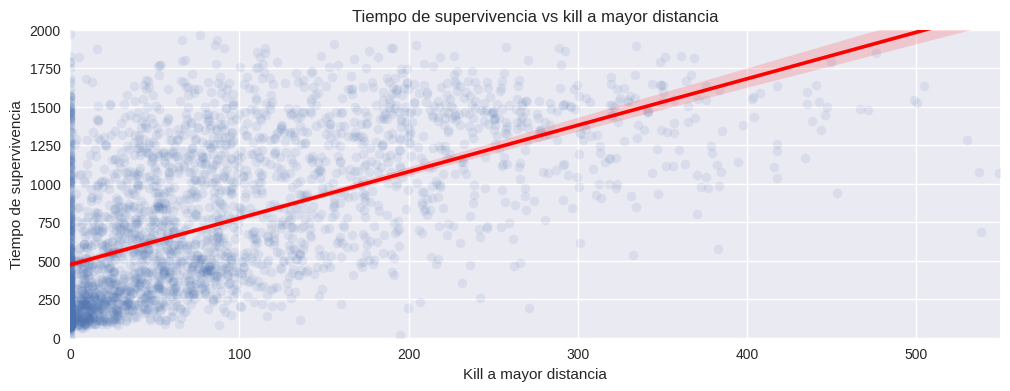

In [ ]:
plt.figure(figsize=(12, 4))
sns.regplot(data=data, x='longestKill', y='timeSurvived',
            scatter_kws={'alpha':.1},
            line_kws={"color": "red"})
plt.xlim((0, 550))
plt.ylim((0, 2000))
plt.xlabel('Kill a mayor distancia')
plt.ylabel('Tiempo de supervivencia')
plt.title('Tiempo de supervivencia vs kill a mayor distancia')
plt.show()

La mayor distancia de una kill tiene una correlación media y positiva con el tiempo de supervivencia. Una kill con un rifle de precisión a gran distancia es posible en cualquier etapa de la partida (suponiendo que el jugador tuvo la suerte de encontrar tanto el mismo como una mira apropiada) pero resulta mas probable en etapas avanzadas de la partida donde probablemente el jugador se encuentre mas equipado.

#### weaponsAcquired

<Figure size 1200x400 with 0 Axes>

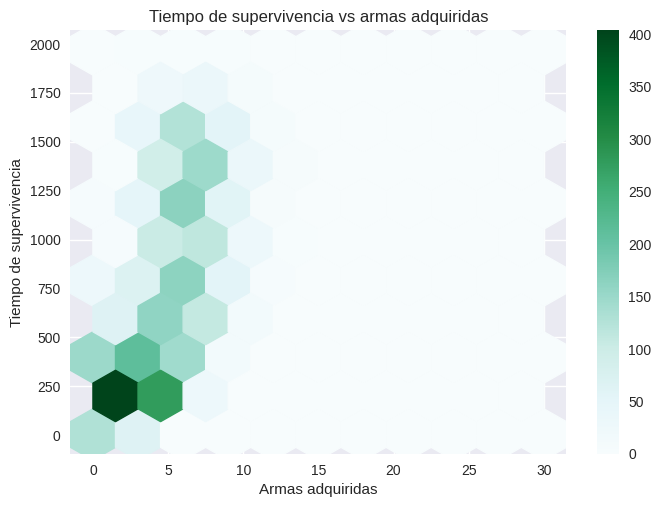

In [ ]:
plt.figure(figsize=(12, 4))
data.plot.hexbin(x='weaponsAcquired', y='timeSurvived', gridsize=10)
plt.xlabel('Armas adquiridas')
plt.ylabel('Tiempo de supervivencia')
plt.title('Tiempo de supervivencia vs armas adquiridas')
plt.show()

El nro de armas adquiridas tiene una correlación media-alta y positiva con el tiempo de supervivencia. Esto tiene sentido, ya que a medida que va pasando el tiempo, un jugador ira cambiando sus armas por otras mejores que vaya encontrando o quitandole a enemigos muertos.

### Insights

A partir del análisis realizado, hemos podido identificar las características que vuelven mas probable que un jugador aumente su tiempo de supervivencia. Siendo estas:

* El nro de boosts utilizados.
* El nro de armas adquiridas.
* Kill a mayor distancia.
* Distancia recorrida en vehículos.

Para nuestro caso de análisis, deberíamos realizar un seguimiento de estos features en el historial de partidas de cada jugador que entre al torneo, ya que estas impactan en el ranking que pueda obtener en la partida.